In [2]:
#install needed packages
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!pip install snorkel
#!pip install textblob
#import libraries and modules
#from google.colab import files
import io
import pandas as pd
#Snorkel
from snorkel.labeling import LabelingFunction
import re
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import labeling_function
#NLP packages
import spacy
from nltk.corpus import stopwords
import string
import nltk
import nltk.tokenize
punc = string.punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#Supervised learning
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


##Deep learning libraries and APIs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN,BatchNormalization,LayerNormalization, Bidirectional

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Sentiment_news_dataframe.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df.head()

,Date,Title,URL,sentiment,confidence,Unnamed: 5
0,03/10/17,Amber Enterprises files for Rs555 crore IPO,http://www.livemint.com/Money/DJCTYXYzpDnVT1Ki...,NEGATIVE,-0.987213,NaN
1,21/04/18,No need to divorce this stock ; brokerage sees...,https://www.moneycontrol.com/news/business/sto...,POSITIVE,0.946583,NaN
2,11/07/18,An evening walk down Dalal Street : Trade war ...,https://www.moneycontrol.com/news/business/mar...,POSITIVE,0.967994,NaN
3,09/01/20,Commodity outlook : Refined soya oil jumps 8 %...,https://economictimes.indiatimes.com/markets/c...,NEGATIVE,-0.879617,NaN
4,19/04/17,Nikkei : Tokyo stocks open lower after British...,http://economictimes.indiatimes.com/markets/st...,NEGATIVE,-0.941918,NaN


In [4]:
#drop irrelevant columns
df = df.drop(['Date','URL','confidence','Unnamed: 5'], axis=1)
df.head()

,Title,sentiment
0,Amber Enterprises files for Rs555 crore IPO,NEGATIVE
1,No need to divorce this stock ; brokerage sees...,POSITIVE
2,An evening walk down Dalal Street : Trade war ...,POSITIVE
3,Commodity outlook : Refined soya oil jumps 8 %...,NEGATIVE
4,Nikkei : Tokyo stocks open lower after British...,NEGATIVE


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      60000 non-null  object
 1   sentiment  60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [6]:
# check for null values
df.isnull().sum()


Title        0
sentiment    0
dtype: int64

In [7]:
#drop duplicates in column "Title"
df = df.drop_duplicates(subset=["Title"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59973 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      59973 non-null  object
 1   sentiment  59973 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [8]:
df = df.rename(columns = {'Title': 'text'})
df['text'] = df['text'].astype(str)

In [9]:
df = df.rename(columns = {'sentiment': 'Label'})
df['Label'] = df['Label'].astype(str)

In [10]:
# Replace Labels positive ,negative by 1 and 0 respectively
df['Label'] = df['Label'].replace({'POSITIVE': 1, 'NEGATIVE': 0})

In [11]:
df.head()

,text,Label
0,Amber Enterprises files for Rs555 crore IPO,0
1,No need to divorce this stock ; brokerage sees...,1
2,An evening walk down Dalal Street : Trade war ...,1
3,Commodity outlook : Refined soya oil jumps 8 %...,0
4,Nikkei : Tokyo stocks open lower after British...,0


In [12]:
label_column = df['Label']

# Count the number of 0s and 1s
zeros_count = label_column.value_counts()[0]
ones_count = label_column.value_counts()[1]


# Display the results
print(f"Number of 0s: {zeros_count}")
print(f"Number of 1s: {ones_count}")

Number of 0s: 29988
Number of 1s: 29985


<AxesSubplot:xlabel='Label', ylabel='count'>

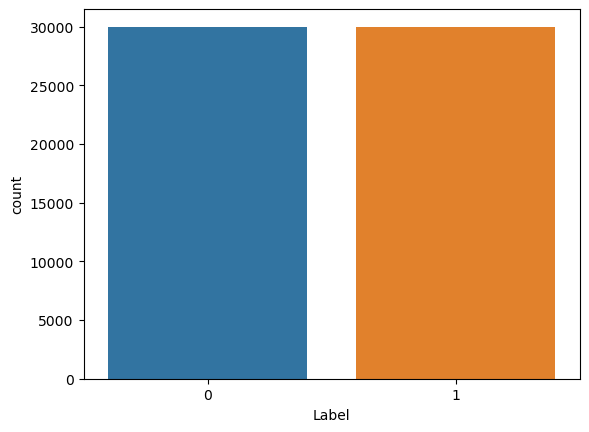

In [54]:
sns.countplot(x=df['Label'])




SpaCy is an open-source library for natural language processing that provides a range of tools for text processing, including tokenization, part-of-speech tagging, named entity recognition, and dependency parsing, among others. The 'en_core_web_sm' model is one of the pre-trained models provided by spaCy for the English language, and it is trained on a large corpus of web text. It is a small-sized model and is suitable for most common NLP tasks that do not require deep contextual understanding.

By loading the 'en_core_web_sm' model, the code initializes an instance of the nlp object, which can then be used to perform various NLP tasks on text data. Once the model is loaded, it is capable of performing several operations such as tokenization, lemmatization, part-of-speech tagging, named entity recognition, dependency parsing, and many more.

After loading the model, the nlp object can be used to process a text string or a document of text data, which will return a Doc object containing a sequence of Token objects, each representing a word or a punctuation mark in the input text. The Doc object can be further processed to extract linguistic features such as part-of-speech tags, named entities, and dependency relationships, among others.

Overall, loading the 'en_core_web_sm' model from the spaCy library is a crucial step for many NLP tasks, as it provides a reliable and efficient way to perform various text processing operations on English text data.

tqdm is an abbreviation for "tqdm" (pronounced "tee-kyoo-dee-em"), which stands for "progress" in Arabic. In programming, tqdm is a Python library that provides a progress bar to show the progress of an iterative process. It can be used to visualize how far a loop has progressed and how much time is remaining until completion. The library is often used in data science and machine learning projects to track the progress of long-running tasks such as data preprocessing, model training, or hyperparameter tuning.





# Pipeline for Tokenisation,Lemmatization,Stopwords and Punctuation removal

In [13]:
#make a copy of the dataframe
data = df.copy()
#define a function which handles the text preprocessing 
def preparation_text_data(data):
    """
    This pipeline prepares the text data, conducting the following steps:
    1) Tokenization
    2) Lemmatization
    4) Removal of stopwords
    5) Removal of punctuation
    """
    # initialize spacy object
    nlp = spacy.load('en_core_web_sm')# The line nlp = spacy.load('en_core_web_sm') is a Python code 
                             #that loads a pre-trained English language model called 'en_core_web_sm' from the spaCy library
    # select raw text
    raw_text = data.text.values.tolist()
    
    # tokenize
    tokenized_text = [[nlp(i.lower().strip())] for i in tqdm(raw_text)]
    # i.lower() converts the string to lowercase characters
    #.strip() removes any leading or trailing white spaces in the string
    # nlp() processes the cleaned string using the NLP library
    # The results are then stored in a new list
    
    #define the punctuations and stop words
    punc = string.punctuation 
    # string.punctuation module is a predefined constant in the string module of Python that contains all the punctuation marks
    
    
    stop_words = set(stopwords.words('english'))
    #code creates a set of stopwords in English language using the stopwords.words() method from the nltk package
    
    #lemmatize, remove stopwords and punctuations
    
    corpus = []
    for doc in tqdm(tokenized_text):
        corpus.append([word.lemma_ for word in doc[0] if (word.lemma_ not in stop_words and word.lemma_ not in punc)])
        #extracts the lemmatized form of each token using the word.lemma_ attribute. The lemma_ attribute is an output of 
        #spaCy's lemmatizer that returns the base form of a word 
    # add prepared data to df
    data["text"] = corpus
    return data
#apply the data preprocessing function
data =  preparation_text_data(data)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20960\1491598785.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tokenized_text = [[nlp(i.lower().strip())] for i in tqdm(raw_text)]


  0%|          | 0/59973 [00:00<?, ?it/s]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_20960\1491598785.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for doc in tqdm(tokenized_text):


  0%|          | 0/59973 [00:00<?, ?it/s]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59973 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    59973 non-null  object
 1   Label   59973 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [15]:
data.head()

,text,Label
0,"[amber, enterprise, file, rs555, crore, ipo]",0
1,"[need, divorce, stock, brokerage, see, 26, ups...",1
2,"[evening, walk, dalal, street, trade, war, fea...",1
3,"[commodity, outlook, refine, soya, oil, jump, ...",0
4,"[nikkei, tokyo, stock, open, lower, british, s...",0


In [16]:
# make copy of dataframe 'data'
data1=data.copy()

# TFIDF Vectorization

TfidfVectorizer() is a function from the scikit-learn library in Python that converts a collection of raw documents into a matrix of TF-IDF features.

TF-IDF stands for "Term Frequency-Inverse Document Frequency". It is a numerical statistic that reflects how important a word is to a document in a collection or corpus. It is calculated as the product of two factors: the term frequency (TF) and the inverse document frequency (IDF).

TF is a measure of how frequently a term appears in a document. IDF is a measure of how rare a term is across all documents in a collection. The product of TF and IDF measures the importance of a term in a document. The TF-IDF score is higher for terms that appear frequently in a document but are rare across all documents in a collection.

The TfidfVectorizer() function takes a collection of raw documents as input and outputs a sparse matrix where each row represents a document and each column represents a unique term in the collection. The values in the matrix are the TF-IDF scores for each term in each document. This matrix can then be used as input to machine learning models for text classification or other natural language processing tasks

In [17]:
def text_representation(data):
  tfidf_vect = TfidfVectorizer()#creates an instance of the TfidfVectorizer class, 
   #which is used for converting text data into a matrix of numerical features.

  data['text'] = data['text'].apply(lambda text: " ".join(set(text))) #removes duplicates from each text in the 'text' column of the 'data' DataFrame and 
    # joins the remaining words with spaces.
    
  X_tfidf = tfidf_vect.fit_transform(data['text']) # transforms the preprocessed text data into a matrix of numerical features using the 
    #fit_transform method of the TfidfVectorizer class.

  print(X_tfidf.shape)
  print(tfidf_vect.get_feature_names()) #displays the list of feature names, which correspond to the unique words in the corpus.
  X_tfidf = pd.DataFrame(X_tfidf.toarray()) # converts the sparse matrix returned by fit_transform into a dense pandas DataFrame.
  return X_tfidf 

In [18]:
#apply the TFIDV function
X_tfidf = text_representation(data)

(59973, 22944)
['00', '000', '000cr', '000mah', '000th', '001', '003', '004', '006', '007', '01', '010', '011', '012', '014', '015', '016', '017', '018', '01st', '02', '020', '021', '024', '026', '028', '029', '02nd', '03', '030', '031', '032', '033', '034', '034cr', '036', '038', '039', '03rd', '04', '040', '042', '043', '045', '046', '047', '04th', '05', '050', '051', '055', '057', '059', '05th', '06', '060', '061', '064', '066', '06th', '07', '070', '071', '072', '073', '074', '075', '076', '07th', '08', '080', '081', '082', '085', '086', '088', '088cr', '089', '08th', '09', '090', '093', '095', '096', '097', '099', '09th', '0l', '10', '100', '1000', '10000', '1000cc', '1000s', '1000x', '100bn', '100cc', '100cr', '100gw', '100mn', '100th', '100x', '101', '10100', '1017', '10175', '102', '10250', '103', '10300', '10350', '10358', '103pt', '104', '10400', '10440', '10450', '105', '10500', '106', '10600', '10650', '107', '10700', '1073', '10750', '108', '10800', '10830', '10850', '108m

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X = X_tfidf
y = data['Label']

Split Data into training and test set - 80% data reserved for train set

In [21]:
#train test split in ratio 80:20 and stratify =y means y is evenly distributed in both the training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression 

In [60]:
#fit Logistic Regression 
lgr = LogisticRegression() #  instantiates a logistic regression model
lgr.fit(X_train,y_train) #  trains the logistic regression model on the training data X_train and 
#corresponding labels y_train, using the fit() method

predict_train_lgr = lgr.predict(X_train) #generate predictions for training data
predict_test_lgr = lgr.predict(X_test)  #generate predictions for test data

train_score_lgr = accuracy_score(predict_train_lgr,y_train) # calculate accuracy of the model predictions for training data
test_score_lgr = accuracy_score(predict_test_lgr,y_test) # calculate accuracy of the model predictions for test data

print("Logistic Regression classification_report:\n",classification_report(y_test, predict_test_lgr)) #classification_report() function generates
#a report that includes various classification metrics such as precision, recall, f1-score, and support for each class.




Logistic Regression classification_report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      5998
           1       0.76      0.78      0.77      5997

    accuracy                           0.77     11995
   macro avg       0.77      0.77      0.77     11995
weighted avg       0.77      0.77      0.77     11995



In [42]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [61]:
precision = precision_score(y_test, predict_test_lgr, average='weighted')
recall = recall_score(y_test, predict_test_lgr, average='weighted')
f1 = f1_score(y_test, predict_test_lgr, average='weighted')
print("Logistic Regression train accuracy:",train_score_lgr)
print("Logistic Regression test accuracy:",test_score_lgr)

# print the precision, recall, and F1 score separately
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Logistic Regression train accuracy: 0.8233982241860853
Logistic Regression test accuracy: 0.7669862442684452
Precision: 0.7671606051367961
Recall: 0.7669862442684452
F1 score: 0.7669485751186704


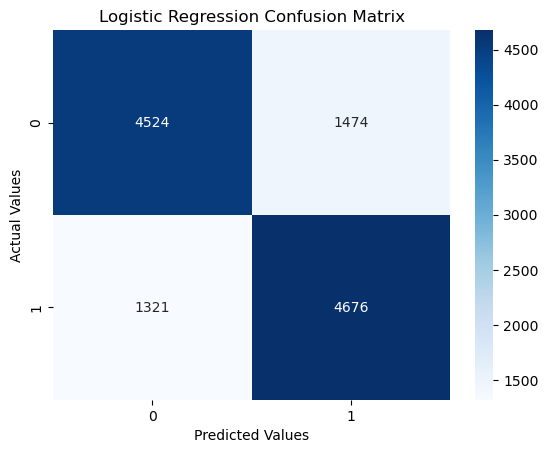

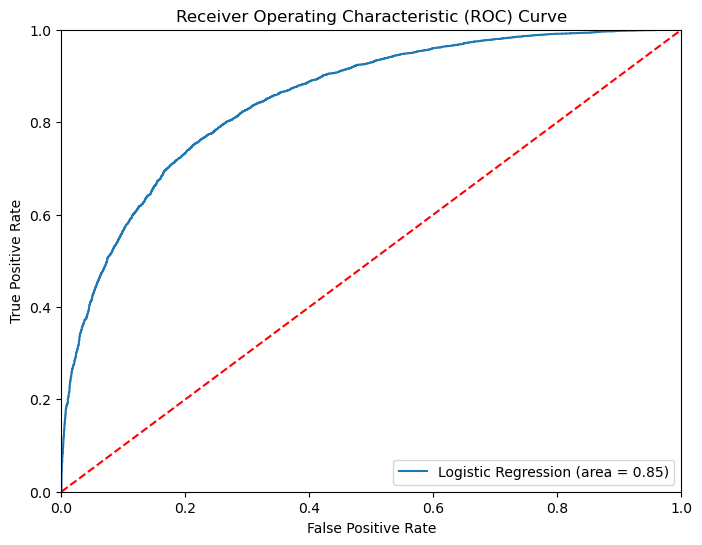

In [62]:
# Confusion matrix
conf_matrix_lgr = confusion_matrix(y_test, predict_test_lgr)
sns.heatmap(conf_matrix_lgr, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# ROC Curve
y_pred_proba_lgr = lgr.predict_proba(X_test)[:,1]
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(y_test, y_pred_proba_lgr)
roc_auc_lgr = roc_auc_score(y_test, y_pred_proba_lgr)

plt.figure(figsize=(8,6))
plt.plot(fpr_lgr, tpr_lgr, label='Logistic Regression (area = %0.2f)' % roc_auc_lgr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Multinomial Naive Bayes

In [24]:
nb = MultinomialNB() #  instantiates a Multinomial Naive Bayes model
params_nb = {'alpha':[0.1,0.5,1]}  #only hyperparameter being tuned is alpha, which is a smoothing parameter 
                                   #used in the Naive Bayes algorithm to avoid zero probabilities.

grid_nb = GridSearchCV(nb,param_grid=params_nb,cv=5)# GridSearchCV function  fits the model to the training data using all the
#possible combinations of hyperparameters specified in the param_grid, evaluates the performance of the model using cross-validation, 
#and selects the set of hyperparameters that gives the best performance based on the specified scoring method

grid_nb.fit(X_train,y_train)#The fit method of GridSearchCV fits the model using all the possible combinations of hyperparameters 
                            #specified in the param_grid

print("Best parameters Naive Bayes:",grid_nb.best_params_) # gives best value of alpha

predict_train_nb = grid_nb.predict(X_train) #generate predictions for training data using best_params
predict_test_nb = grid_nb.predict(X_test)  #generate predictions for test data using best_params

train_score_nb = accuracy_score(predict_train_nb,y_train) ## calculate accuracy of the model predictions for training data
test_score_nb = accuracy_score(predict_test_nb,y_test) ##  calculate accuracy of the model predictions for test data

print("Naive Bayes classification_report:\n",classification_report(y_test, predict_test_nb)) ##classification_report() function generates
#a report that includes various classification metrics such as precision, recall, f1-score, and support for each class.

print("Naive Bayes train accuracy:",train_score_nb)
print("Naive Bayes test accuracy:",test_score_nb)




Best parameters Naive Bayes: {'alpha': 1}
Naive Bayes classification_report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75      5998
           1       0.76      0.71      0.74      5997

    accuracy                           0.74     11995
   macro avg       0.74      0.74      0.74     11995
weighted avg       0.74      0.74      0.74     11995

Naive Bayes train accuracy: 0.8084121889199216
Naive Bayes test accuracy: 0.7436431846602751


In [44]:
# extract precision, recall, and F1 score from the classification report
precision = precision_score(y_test, predict_test_nb, average='weighted')
recall = recall_score(y_test, predict_test_nb, average='weighted')
f1 = f1_score(y_test, predict_test_nb, average='weighted')

# print the precision, recall, and F1 score separately
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)



Precision: 0.7445981164253365
Recall: 0.7436431846602751
F1 score: 0.7433917122051327


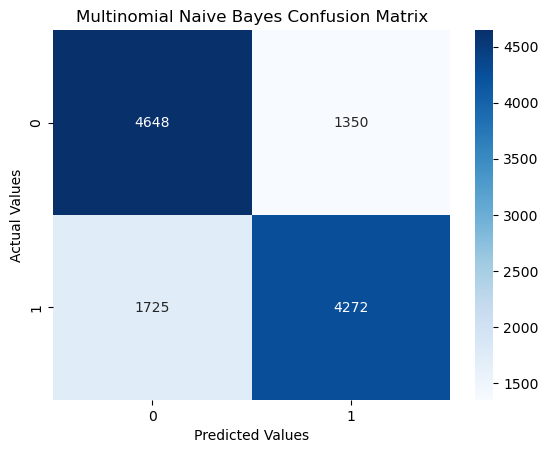

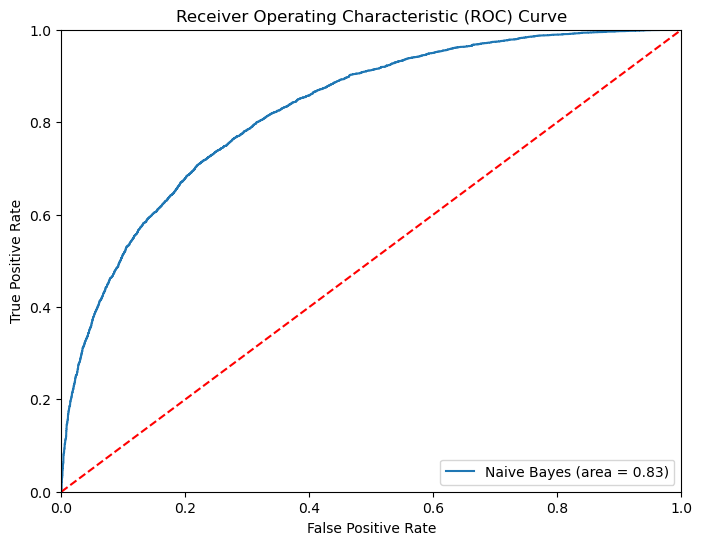

In [39]:
# Confusion matrix

conf_matrix_nb = confusion_matrix(y_test, predict_test_nb)
sns.heatmap(conf_matrix_nb, annot=True, cmap='Blues', fmt='g')
plt.title('Multinomial Naive Bayes Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# ROC Curve
y_pred_proba_nb = grid_nb.predict_proba(X_test)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_proba_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb)

plt.figure(figsize=(8,6))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.2f)' % roc_auc_nb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Decision Tree Classifier

In [26]:
detr = DecisionTreeClassifier() #  instantiates Decision Tree Classifier
params_detr = {'max_depth':[50,75,100]}  ##  max_depth hyperparameter controls the depth of the decision tree, 
                                         #which in turn controls the complexity of the model. .

grid_detr = GridSearchCV(detr,param_grid=params_detr,cv=5)# GridSearchCV function  fits the model to the training data using all the
#possible combinations of hyperparameters specified in the param_grid, evaluates the performance of the model using cross-validation, 
#and selects the set of hyperparameters that gives the best performance based on the specified scoring method


grid_detr.fit(X_train,y_train)#The fit method of GridSearchCV fits the model using all the possible combinations of hyperparameters 
                            #specified in the param_grid

print("Best parameters of DecisionTree:",grid_detr.best_params_) ## gives best value of "max depth" 

predict_train_detr = grid_detr.predict(X_train)#generate predictions for training data using best_params
predict_test_detr = grid_detr.predict(X_test)  #generate predictions for test data using best_params

train_score_detr = accuracy_score(predict_train_detr,y_train) ## calculate accuracy of the model predictions for training data
test_score_detr = accuracy_score(predict_test_detr,y_test)  ##  calculate accuracy of the model predictions for test data

print("Decision Tree classification_report:\n",classification_report(y_test, predict_test_detr)) ##classification_report() function generates
#a report that includes various classification metrics such as precision, recall, f1-score, and support for each class


Best parameters of DecisionTree: {'max_depth': 100}
Decision Tree classification_report:
               precision    recall  f1-score   support

           0       0.72      0.52      0.61      5998
           1       0.63      0.80      0.70      5997

    accuracy                           0.66     11995
   macro avg       0.67      0.66      0.65     11995
weighted avg       0.67      0.66      0.65     11995



In [45]:
print("Decision Tree train accuracy:",train_score_detr)
print("Decision Tree test accuracy:",test_score_detr)

# extract precision, recall, and F1 score from the classification report
precision = precision_score(y_test, predict_test_lgr, average='weighted')
recall = recall_score(y_test, predict_test_lgr, average='weighted')
f1 = f1_score(y_test, predict_test_lgr, average='weighted')

# print the precision, recall, and F1 score separately
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Decision Tree train accuracy: 0.831839593146859
Decision Tree test accuracy: 0.6603584827011255
Precision: 0.7671606051367961
Recall: 0.7669862442684452
F1 score: 0.7669485751186704


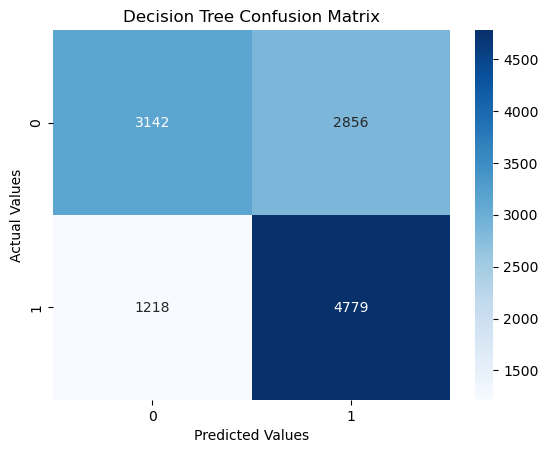

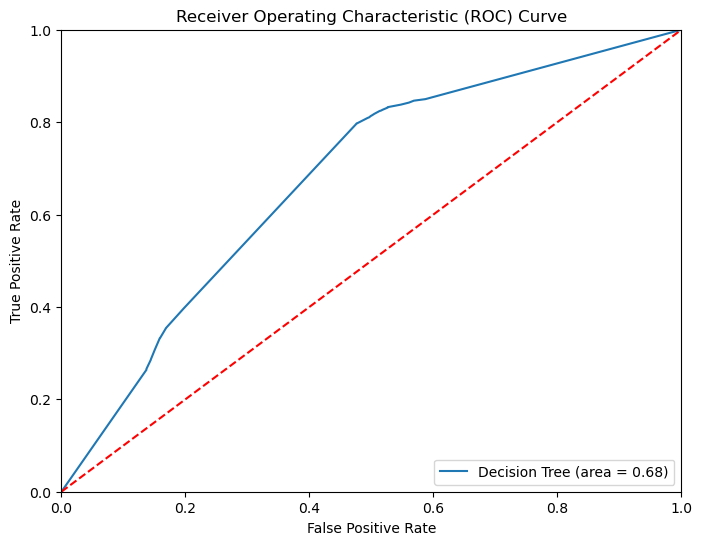

In [40]:
# Confusion matrix

conf_matrix_detr = confusion_matrix(y_test, predict_test_detr)
sns.heatmap(conf_matrix_detr, annot=True, cmap='Blues', fmt='g')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# ROC Curve
y_pred_proba_detr = grid_detr.predict_proba(X_test)[:,1]
fpr_detr, tpr_detr, thresholds_detr = roc_curve(y_test, y_pred_proba_detr)
roc_auc_detr = roc_auc_score(y_test, y_pred_proba_detr)

plt.figure(figsize=(8,6))
plt.plot(fpr_detr, tpr_detr, label='Decision Tree (area = %0.2f)' % roc_auc_detr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Random Forest

In [46]:
rf = RandomForestClassifier(random_state=0)  #  instantiates Random Forest Classifier model

In [47]:
params_rf={'max_depth':[20,50,100],'n_estimators':[100,200,300]} # hyperparameters to be tuned    

In [48]:
grid_rf = GridSearchCV(rf,param_grid=params_rf,cv=5) #  gridsearch to find best parameters
grid_rf.fit(X_train,y_train)#The fit method of GridSearchCV fits the model using all the possible combinations of hyperparameters 
                            #specified in the param_grid

print("Best parameters of RandomForest:",grid_rf.best_params_)# gives best value of 'max-depth' and 'n estimators'
predict_train_rf = grid_rf.predict(X_train)#generate predictions for training data using best_params
predict_test_rf = grid_rf.predict(X_test)#generate predictions for test data using best_params

train_score_rf = accuracy_score(predict_train_rf,y_train) ## calculate accuracy of the model predictions for training data
test_score_rf = accuracy_score(predict_test_rf,y_test)## calculate accuracy of the model predictions for testing data

print("RandomForest train accuracy:",train_score_rf) ## calculate accuracy of the model predictions for training data
print("RandomForest test accuracy:",test_score_rf) ## calculate accuracy of the model predictions for testing data

print("RandomForest classification_report:\n",classification_report(y_test, predict_test_rf))##classification_report() function generates
#a report that includes various classification metrics such as precision, recall, f1-score, and support for each class




Best parameters of RandomForest: {'max_depth': 100, 'n_estimators': 300}
RandomForest train accuracy: 0.9067906123640002
RandomForest test accuracy: 0.730054189245519
RandomForest classification_report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.71      5998
           1       0.71      0.79      0.74      5997

    accuracy                           0.73     11995
   macro avg       0.73      0.73      0.73     11995
weighted avg       0.73      0.73      0.73     11995



In [49]:
print("Random Forest train accuracy:",train_score_rf)
print("Random Forest test accuracy:",test_score_rf)

# extract precision, recall, and F1 score from the classification report
precision = precision_score(y_test, predict_test_rf, average='weighted')
recall = recall_score(y_test, predict_test_rf, average='weighted')
f1 = f1_score(y_test, predict_test_rf, average='weighted')

# print the precision, recall, and F1 score separately
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Random Forest train accuracy: 0.9067906123640002
Random Forest test accuracy: 0.730054189245519
Precision: 0.7328767726326695
Recall: 0.730054189245519
F1 score: 0.7292356900160852


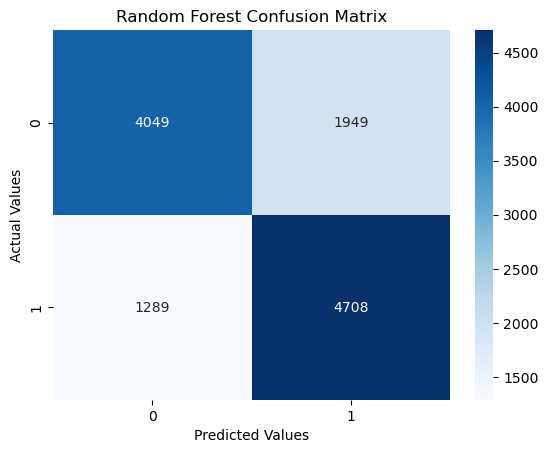

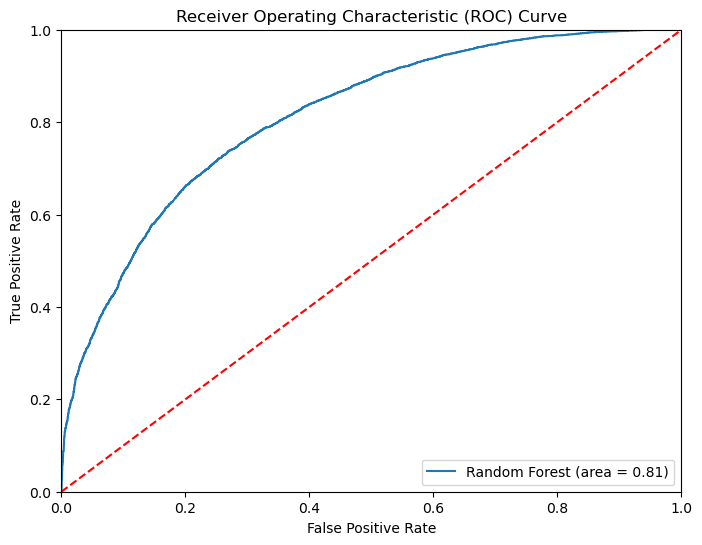

In [50]:
# Confusion matrix

conf_matrix_rf = confusion_matrix(y_test, predict_test_rf)
sns.heatmap(conf_matrix_rf, annot=True, cmap='Blues', fmt='g')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# ROC Curve
y_pred_proba_rf = grid_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# XGBOOST 

In [55]:
xgb = xgb.XGBClassifier() #  instantiates XGBoost model
params_xgb = {'n_estimators':[100,200,300],'learning_rate':[0.01,0.1,0.5]}    # hyperparameters to be tuned 

grid_xgb = GridSearchCV(xgb,param_grid=params_xgb,cv=5) #  gridsearch to find best parameters
grid_xgb.fit(X_train,y_train) #The fit method of GridSearchCV fits the model using all the possible combinations of hyperparameters 
                            #specified in the param_grid

print("Best parameters of XGBoost:",grid_xgb.best_params_) # gives best value of 'learning_rate' and 'n estimators'

predict_train_xgb = grid_xgb.predict(X_train) #generate predictions for training data using best_params
predict_test_xgb = grid_xgb.predict(X_test) #generate predictions for testing data using best_params

train_score_xgb = accuracy_score(predict_train_xgb,y_train) ## calculate accuracy of the model predictions for training data
test_score_xgb = accuracy_score(predict_test_xgb,y_test) ## calculate accuracy of the model predictions for testing data

print("XGBoost classification_report:\n",classification_report(y_test, predict_test_xgb))##classification_report() function generates
#a report that includes various classification metrics such as precision, recall, f1-score, and support for each class



Best parameters of XGBoost: {'learning_rate': 0.5, 'n_estimators': 300}
XGBoost classification_report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      5998
           1       0.74      0.78      0.76      5997

    accuracy                           0.75     11995
   macro avg       0.75      0.75      0.75     11995
weighted avg       0.75      0.75      0.75     11995



In [58]:
print("XGBoost train accuracy:",train_score_xgb)
print("XGBoost test accuracy:",test_score_xgb)

# extract precision, recall, and F1 score from the classification report
precision = precision_score(y_test, predict_test_xgb, average='weighted')
recall = recall_score(y_test, predict_test_xgb, average='weighted')
f1 = f1_score(y_test, predict_test_xgb, average='weighted')

# print the precision, recall, and F1 score separately
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


XGBoost train accuracy: 0.8501396473383634
XGBoost test accuracy: 0.7523134639433097
Precision: 0.7532321695262855
Recall: 0.7523134639433097
F1 score: 0.7520895387463865


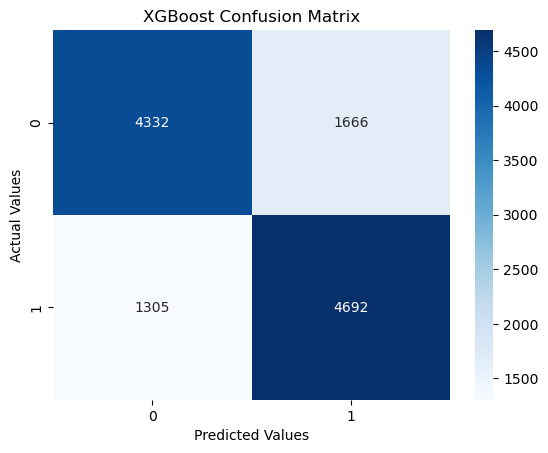

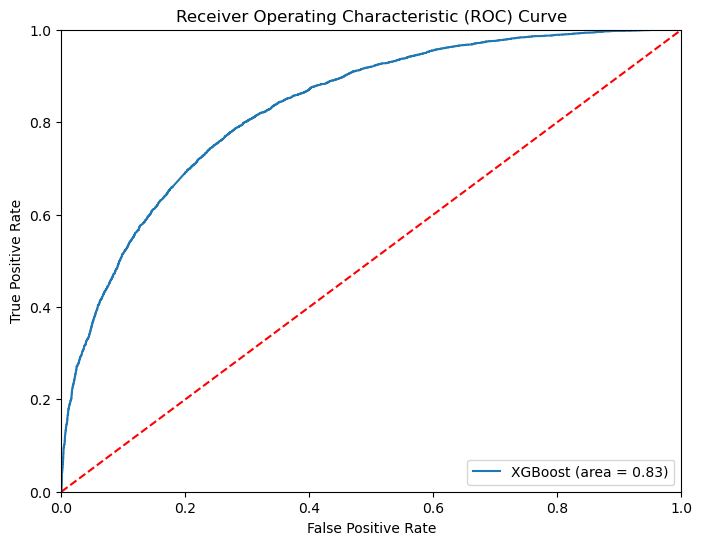

In [59]:
# Confusion matrix

conf_matrix_xgb = confusion_matrix(y_test, predict_test_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='g')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

# ROC Curve
y_pred_proba_xgb = grid_xgb.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
